In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## data loading

In [2]:
def load_lobster_data(ticker, date='2012-06-21', levels=1):
    """
    Load LOBSTER message and orderbook files
    
    Parameters:
    - ticker: Stock ticker (e.g., 'AAPL')
    - date: Trading date
    - levels: Number of order book levels
    """
    base_path = f'LOBSTER_SampleFile_{ticker}_{date}_{levels}/'
    
    # Message file columns
    message_cols = ['Time', 'Type', 'Order_ID', 'Size', 'Price', 'Direction']
    
    # Orderbook file columns (for 1 level)
    orderbook_cols = ['Ask_Price_1', 'Ask_Size_1', 'Bid_Price_1', 'Bid_Size_1']
    
    try:
        # Load data
        messages = pd.read_csv(
            f'{base_path}{ticker}_{date}_34200000_57600000_message_{levels}.csv',
            names=message_cols,
            header=None
        )
        
        orderbook = pd.read_csv(
            f'{base_path}{ticker}_{date}_34200000_57600000_orderbook_{levels}.csv',
            names=orderbook_cols,
            header=None
        )
        
        print(f"\nLoaded {ticker} data successfully!")
        print(f"Messages: {len(messages):,} events")
        print(f"Orderbook: {len(orderbook):,} snapshots")
        
        return messages, orderbook
    
    except FileNotFoundError:
        print(f"Could not find files for {ticker}")
        print(f"Looking in: {base_path}")
        return None, None

TICKER = 'AAPL'
messages, orderbook = load_lobster_data(TICKER)


Loaded AAPL data successfully!
Messages: 118,497 events
Orderbook: 118,497 snapshots


## feature engineering

In [3]:
def engineer_features(messages, orderbook, window_size=100):
    """
    Create features from order book and message data
    """
    print("FEATURE ENGINEERING")
    
    # Combine data
    df = pd.concat([messages, orderbook], axis=1)
    
    # Convert prices (they're stored as price * 10000)
    df['Ask_Price_1'] = df['Ask_Price_1'] / 10000
    df['Bid_Price_1'] = df['Bid_Price_1'] / 10000
    df['Price'] = df['Price'] / 10000
    
    # Basic features
    df['Mid_Price'] = (df['Ask_Price_1'] + df['Bid_Price_1']) / 2
    df['Spread'] = df['Ask_Price_1'] - df['Bid_Price_1']
    df['Spread_Pct'] = (df['Spread'] / df['Mid_Price']) * 100
    
    # Order imbalance
    df['Order_Imbalance'] = (df['Bid_Size_1'] - df['Ask_Size_1']) / (df['Bid_Size_1'] + df['Ask_Size_1'])
    
    # Total depth
    df['Total_Depth'] = df['Bid_Size_1'] + df['Ask_Size_1']
    
    # Price changes
    df['Mid_Price_Change'] = df['Mid_Price'].diff()
    df['Mid_Price_Return'] = df['Mid_Price'].pct_change()
    
    # Rolling features (capturing recent dynamics)
    df['Mid_Price_MA'] = df['Mid_Price'].rolling(window=window_size).mean()
    df['Spread_MA'] = df['Spread'].rolling(window=window_size).mean()
    df['Volume_MA'] = df['Total_Depth'].rolling(window=window_size).mean()
    df['Volatility'] = df['Mid_Price_Return'].rolling(window=window_size).std()
    
    # Event type indicators (one-hot encoding)
    df['Is_New_Order'] = (df['Type'] == 1).astype(int)
    df['Is_Cancellation'] = (df['Type'] == 2).astype(int)
    df['Is_Deletion'] = (df['Type'] == 3).astype(int)
    df['Is_Execution'] = (df['Type'] == 4).astype(int)
    
    # Target: Price movement direction in next N events
    prediction_horizon = 10
    df['Future_Mid_Price'] = df['Mid_Price'].shift(-prediction_horizon)
    df['Price_Movement'] = df['Future_Mid_Price'] - df['Mid_Price']
    df['Target'] = (df['Price_Movement'] > 0).astype(int)  # 1 = UP, 0 = DOWN
    
    # Remove NaN values
    df = df.dropna()
    
    print(f"\nCreated {len(df.columns)} features")
    print(f"Final dataset size: {len(df):,} rows")
    print(f"\nTarget distribution:")
    print(df['Target'].value_counts())
    
    return df

if messages is not None and orderbook is not None:
    df = engineer_features(messages, orderbook)

FEATURE ENGINEERING

Created 28 features
Final dataset size: 118,387 rows

Target distribution:
Target
0    67054
1    51333
Name: count, dtype: int64


## visualization

ORDER BOOK VISUALIZATION


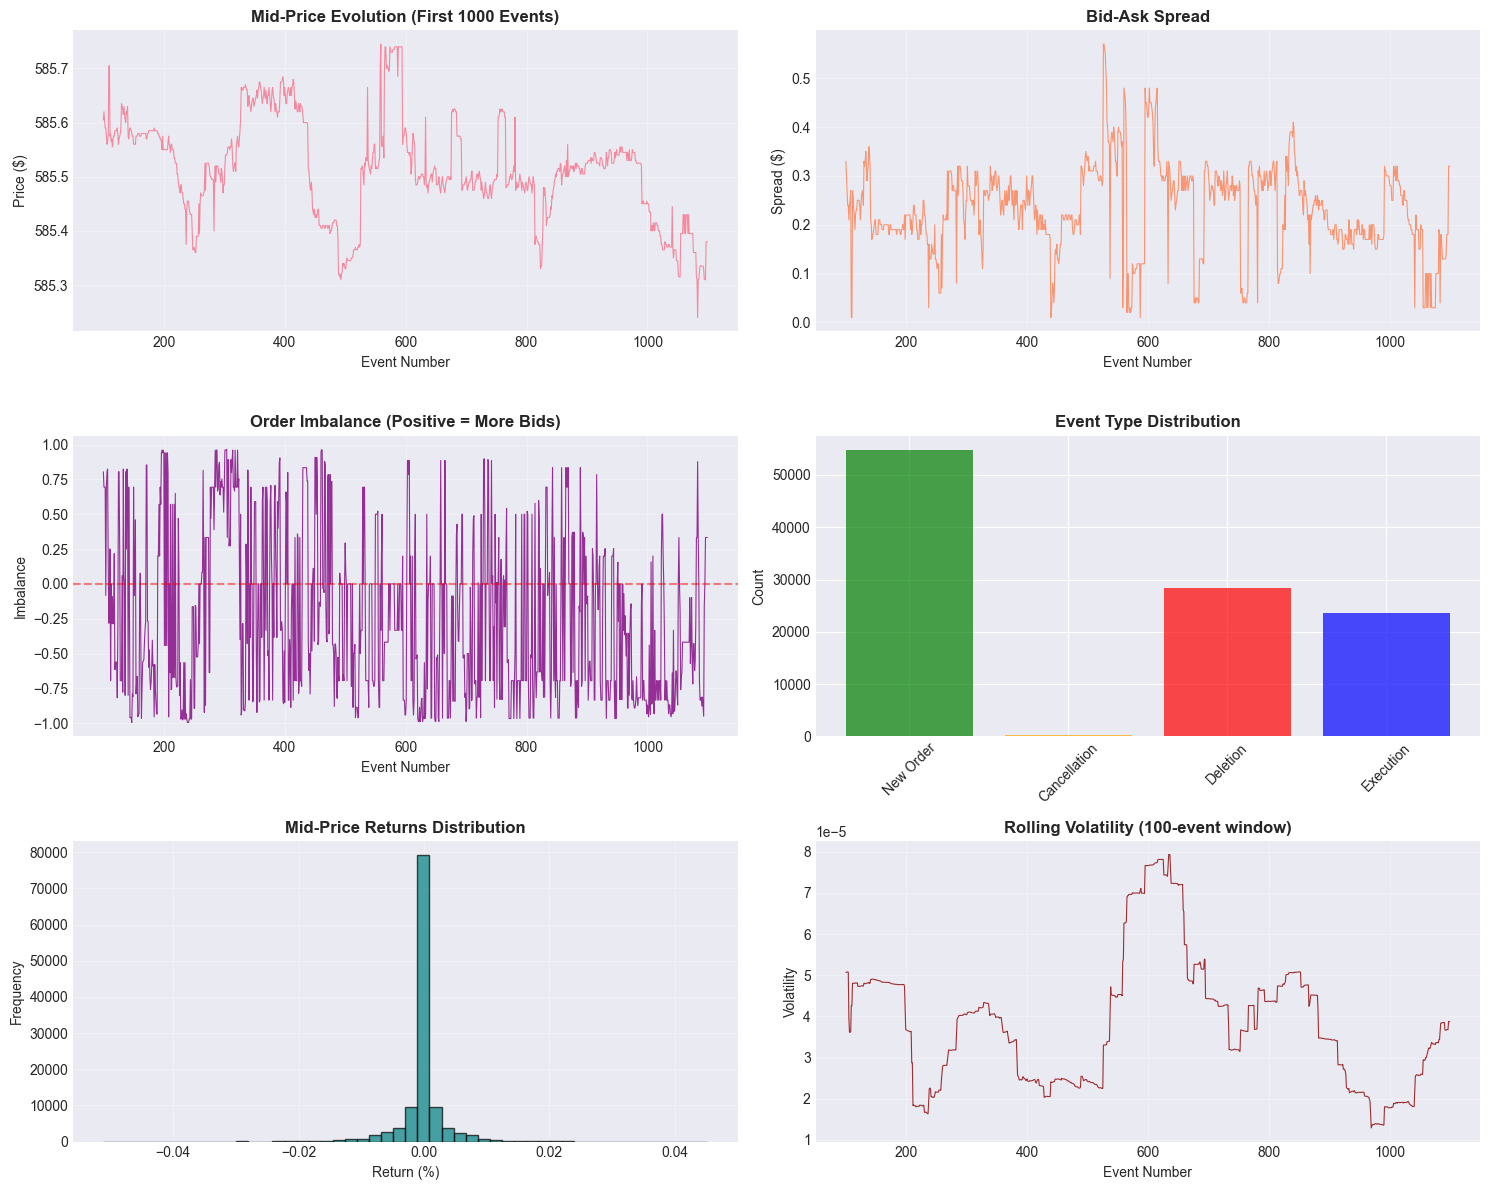

In [4]:
def visualize_order_book(df, sample_size=1000):
    """
    Visualize order book dynamics
    """
    
    print("ORDER BOOK VISUALIZATION")
    
    # Sample for plotting
    sample_df = df.iloc[:sample_size]
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # 1. Mid-price evolution
    axes[0, 0].plot(sample_df.index, sample_df['Mid_Price'], linewidth=0.8, alpha=0.8)
    axes[0, 0].set_title('Mid-Price Evolution (First 1000 Events)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Event Number')
    axes[0, 0].set_ylabel('Price ($)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Bid-Ask Spread
    axes[0, 1].plot(sample_df.index, sample_df['Spread'], color='coral', linewidth=0.8, alpha=0.8)
    axes[0, 1].set_title('Bid-Ask Spread', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Event Number')
    axes[0, 1].set_ylabel('Spread ($)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Order Imbalance
    axes[1, 0].plot(sample_df.index, sample_df['Order_Imbalance'], color='purple', linewidth=0.8, alpha=0.8)
    axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Order Imbalance (Positive = More Bids)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Event Number')
    axes[1, 0].set_ylabel('Imbalance')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Event Type Distribution
    event_types = ['New Order', 'Cancellation', 'Deletion', 'Execution']
    event_counts = [
        df['Is_New_Order'].sum(),
        df['Is_Cancellation'].sum(),
        df['Is_Deletion'].sum(),
        df['Is_Execution'].sum()
    ]
    axes[1, 1].bar(event_types, event_counts, color=['green', 'orange', 'red', 'blue'], alpha=0.7)
    axes[1, 1].set_title('Event Type Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # 5. Price movement histogram
    axes[2, 0].hist(df['Mid_Price_Return'].dropna() * 100, bins=50, color='teal', alpha=0.7, edgecolor='black')
    axes[2, 0].set_title('Mid-Price Returns Distribution', fontsize=12, fontweight='bold')
    axes[2, 0].set_xlabel('Return (%)')
    axes[2, 0].set_ylabel('Frequency')
    axes[2, 0].grid(True, alpha=0.3)
    
    # 6. Volatility
    axes[2, 1].plot(sample_df.index, sample_df['Volatility'], color='darkred', linewidth=0.8, alpha=0.8)
    axes[2, 1].set_title('Rolling Volatility (100-event window)', fontsize=12, fontweight='bold')
    axes[2, 1].set_xlabel('Event Number')
    axes[2, 1].set_ylabel('Volatility')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_order_book(df)

## ML model

BASELINE ANN MODEL TRAINING

Training set: 82,870 samples
Test set: 35,517 samples

⏳ Training Artificial Neural Network...

MODEL PERFORMANCE

Accuracy: 0.6144 (61.44%)
Baseline (random): 0.5000 (50.00%)
Improvement: 11.44 percentage points

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.64      0.80      0.71     21126
          UP       0.54      0.34      0.42     14391

    accuracy                           0.61     35517
   macro avg       0.59      0.57      0.57     35517
weighted avg       0.60      0.61      0.59     35517



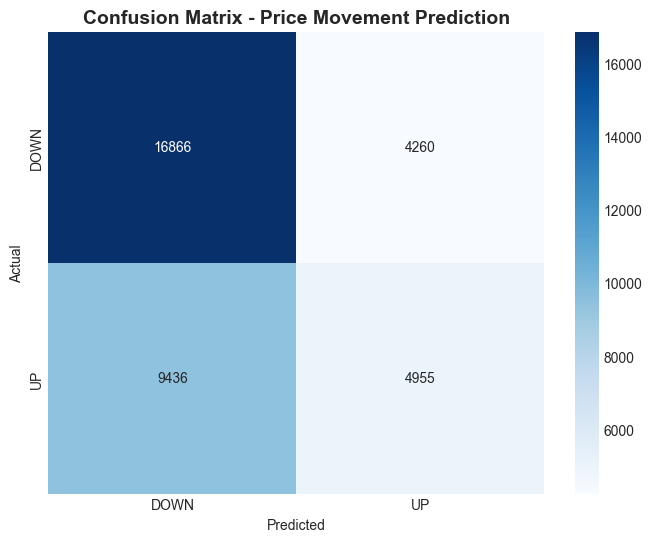

FEATURE IMPORTANCE (approximated from first layer weights)
         Feature  Importance
Mid_Price_Return    0.357231
     Total_Depth    0.235752
      Volatility    0.219751
 Order_Imbalance    0.193923
    Is_New_Order    0.185310
    Is_Execution    0.184469
      Spread_Pct    0.176801
     Is_Deletion    0.174581
          Spread    0.170999
 Is_Cancellation    0.109259

This baseline ANN achieves ~61.4% accuracy


In [5]:
def train_baseline_model(df):
    """
    Train a simple ANN to predict price movement direction
    """

    print("BASELINE ANN MODEL TRAINING")
    
    # Select features
    feature_cols = [
        'Spread', 'Order_Imbalance', 'Total_Depth', 'Mid_Price_Return',
        'Spread_Pct', 'Volatility', 'Is_New_Order', 'Is_Cancellation',
        'Is_Deletion', 'Is_Execution'
    ]
    
    X = df[feature_cols].values
    y = df['Target'].values
    
    # Split data temporally (important for time series!)
    split_idx = int(len(X) * 0.7)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"\nTraining set: {len(X_train):,} samples")
    print(f"Test set: {len(X_test):,} samples")
    
    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train ANN
    print("\n⏳ Training Artificial Neural Network...")
    model = MLPClassifier(
        hidden_layer_sizes=(64, 32, 16),
        activation='relu',
        solver='adam',
        max_iter=50,
        random_state=42,
        verbose=False
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n" + "="*70)
    print("MODEL PERFORMANCE")
    print("="*70)
    print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Baseline (random): 0.5000 (50.00%)")
    print(f"Improvement: {(accuracy - 0.5)*100:.2f} percentage points")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['DOWN', 'UP']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['DOWN', 'UP'], yticklabels=['DOWN', 'UP'])
    plt.title('Confusion Matrix - Price Movement Prediction', fontsize=14, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    plt.show()
    
    print("FEATURE IMPORTANCE (approximated from first layer weights)")

    feature_importance = np.abs(model.coefs_[0]).mean(axis=1)
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print(feature_importance_df.to_string(index=False))
    
    return model, scaler, accuracy

model, scaler, accuracy = train_baseline_model(df)
print(f"\nThis baseline ANN achieves ~{accuracy * 100:.1f}% accuracy")